In [2]:
# General
from __future__ import unicode_literals

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + Custom environments
import sys, os
sys.path.append(os.path.abspath('../'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_maze

In [3]:
# Custom function for obtaining available environments
filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods") or env.id.startswith("Corridor")

all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze4-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze6-v0], non-deterministic: [True], trials: [100]
Maze ID: [Woods1-v0], non-deterministic: [False], trials: [100]
Maze ID: [Woods14-v0], non-deterministic: [False], trials: [100]


In [4]:
# MAZE = "Woods14-v0"
MAZE = "Maze5-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ □ $ ■
■ □ □ ■ □ ■ ■ □ ■
■ □ ■ □ □ □ □ □ ■
■ □ □ □ ■ ■ □ □ ■
■ □ ■ □ ■ □ □ ■ ■
■ □ ■ □ □ ■ □ □ ■
■ □ □ □ □ □ ■ A ■
■ ■ ■ ■ ■ ■ ■ ■ ■


In [5]:
situation

('0', '1', '1', '1', '1', '1', '1', '0')

In [6]:
ACTION = 1 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print(f"New state: {state}, reward: {reward}, is done: {done}")

# Render the env one more time after executing step
maze.render()

New state: ('0', '1', '1', '1', '1', '1', '1', '0'), reward: 0, is done: False

■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ □ $ ■
■ □ □ ■ □ ■ ■ □ ■
■ □ ■ □ □ □ □ □ ■
■ □ □ □ ■ ■ □ □ ■
■ □ ■ □ ■ □ □ ■ ■
■ □ ■ □ □ ■ □ □ ■
■ □ □ □ □ □ ■ A ■
■ ■ ■ ■ ■ ■ ■ ■ ■


In [7]:
def _maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(*start)
        p1 = environment.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

from lcs.metrics import population_metrics

def _maze_metrics(pop, env):
    metrics = {
        'knowledge': _maze_knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))

    return metrics

In [8]:
CLASSIFIER_LENGTH=8
NUMBER_OF_POSSIBLE_ACTIONS=8

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    metrics_trial_frequency=1,
    user_metrics_collector_fcn=_maze_metrics)

# Define agent
agent = ACS2(cfg)

In [9]:
%%time
population, metrics = agent.explore(maze, 100)

Wall time: 4.31 s


In [10]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

9####010 0 1####101         (empty)               q: 0.948 r: 895.3  ir: 895.3  f: 848.5  exp: 44  tga: 165   talp: 3783  tav: 65.6   num: 1 	q: 0.95 	r: 895.33 	ir: 895.33
10000101 1 9111#010         (empty)               q: 0.953 r: 531.6  ir: 0.0    f: 506.5  exp: 36  tga: 835   talp: 3771  tav: 72.5   num: 1 	q: 0.95 	r: 531.65 	ir: 0.00
1000#101 1 9111#010         (empty)               q: 0.925 r: 531.9  ir: 0.0    f: 492.0  exp: 36  tga: 835   talp: 3771  tav: 71.3   num: 1 	q: 0.93 	r: 531.90 	ir: 0.00
01##0#01 0 9#####10         (empty)               q: 0.881 r: 390.0  ir: 0.0    f: 343.7  exp: 21  tga: 1485  talp: 3686  tav: 1.11e+02 num: 1 	q: 0.88 	r: 390.04 	ir: 0.00
0###0001 0 9#####10         (empty)               q: 0.868 r: 390.9  ir: 0.0    f: 339.4  exp: 22  tga: 1416  talp: 3686  tav: 1.12e+02 num: 1 	q: 0.87 	r: 390.85 	ir: 0.00
0#1##001 0 9#####10         (empty)               q: 0.868 r: 390.4  ir: 0.0    f: 339.0  exp: 21  tga: 1485  talp: 3686  tav: 1.1e+02 num:

In [11]:

# Reinitialize agent using defined configuration and population
agent = ACS2(cfg, population)

In [12]:
population, metrics = agent.exploit(maze, 1)

In [13]:
metrics[-1]


{'trial': 0,
 'steps_in_trial': 5,
 'reward': 1000,
 'knowledge': 30.82191780821918,
 'population': 442,
 'numerosity': 442,
 'reliable': 98}

EXPERIMENTS

In [14]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row

    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)

    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'

    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)

    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)

    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)

    return df

def find_best_classifier(population, situation, cfg):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]

    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)

    return None

def build_fitness_matrix(env, population, cfg):
    original = env.env.maze.matrix
    fitness = original.copy()

    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1

        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0

        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500

    return fitness

def build_action_matrix(env, population, cfg):
    ACTION_LOOKUP = {
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }

    original = env.env.maze.matrix
    action = original.copy().astype(str)

    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'

        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'

        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'

    return action

In [15]:
# Plot constants
TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16

In [16]:
def plot_policy(env, agent, cfg, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_aspect("equal")

    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = env.env.maze.max_x
    max_y = env.env.maze.max_y

    fitness_matrix = build_fitness_matrix(env, agent.population, cfg)
    action_matrix = build_action_matrix(env, agent.population, cfg)

    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])


    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))

    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)

    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))

    ax.grid(True)

def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])

def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)

def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')

    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)

def plot_performance(agent, maze, metrics_df, cfg, env_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2 Performance in {env_name} environment', fontsize=32)

    ax1 = plt.subplot(221)
    plot_policy(maze, agent, cfg, ax1)

    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)

    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)

    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)

    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

Maze5 

In [17]:

%%time

# define environment
maze5 = gym.make('Maze5-v0')

# explore
agent_maze5 = ACS2(cfg)
population_maze5_explore, metrics_maze5_explore = agent_maze5.explore(maze5, 3000)

# exploit
agent_maze5 = ACS2(cfg, population_maze5_explore)
_, metrics_maze5_exploit = agent_maze5.exploit(maze5, 400)

Wall time: 3min 48s


In [18]:
maze5_metrics_df = parse_metrics_to_df(metrics_maze5_explore, metrics_maze5_exploit)


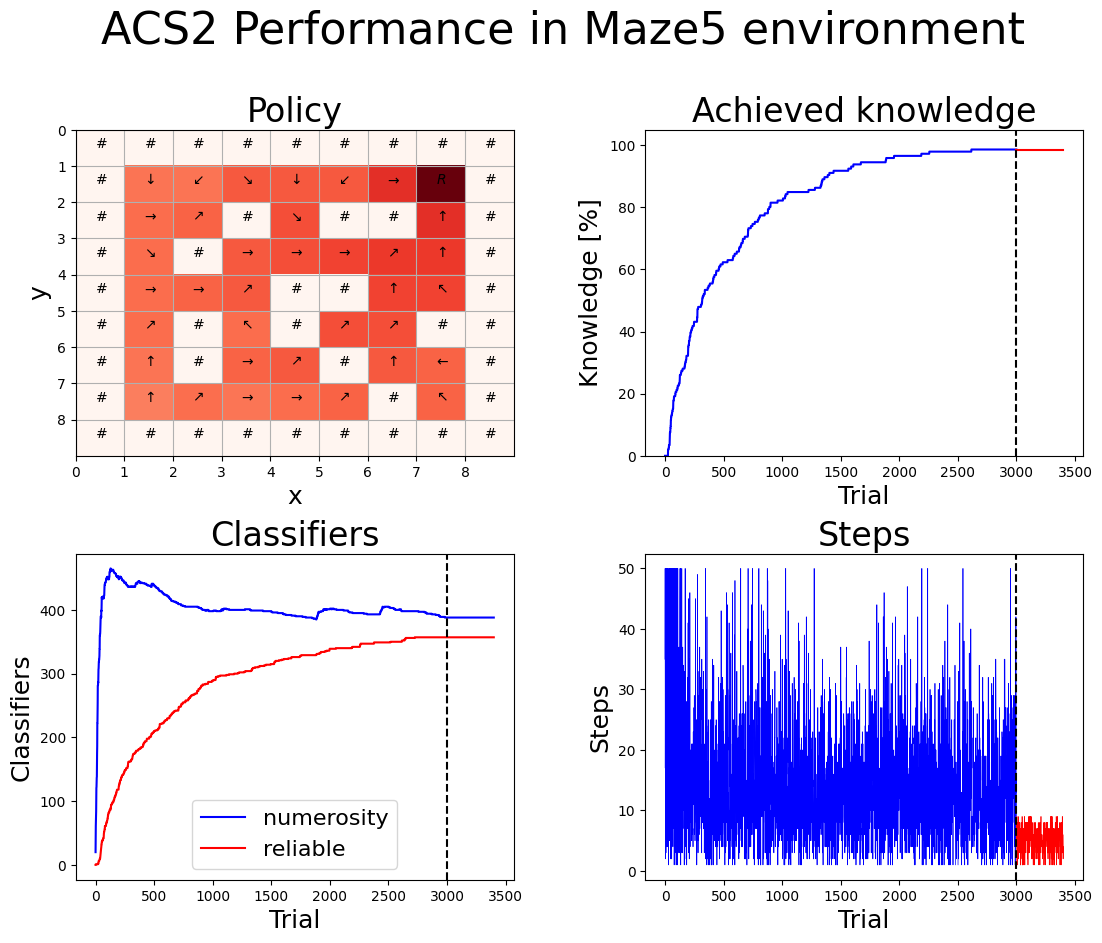

In [19]:
plot_performance(agent_maze5, maze5, maze5_metrics_df, cfg, 'Maze5')


Woods14

In [20]:
%%time

# define environment
woods14 = gym.make('Woods14-v0')

# explore
agent_woods14 = ACS2(cfg)
population_woods14_explore, metrics_woods14_explore = agent_woods14.explore(woods14, 1000)

# exploit
agent_woods14 = ACS2(cfg, population_woods14_explore)
_, metrics_woods14_exploit = agent_woods14.exploit(woods14, 200)

Wall time: 18.7 s


In [21]:
woods14_metrics_df = parse_metrics_to_df(metrics_woods14_explore, metrics_woods14_exploit)

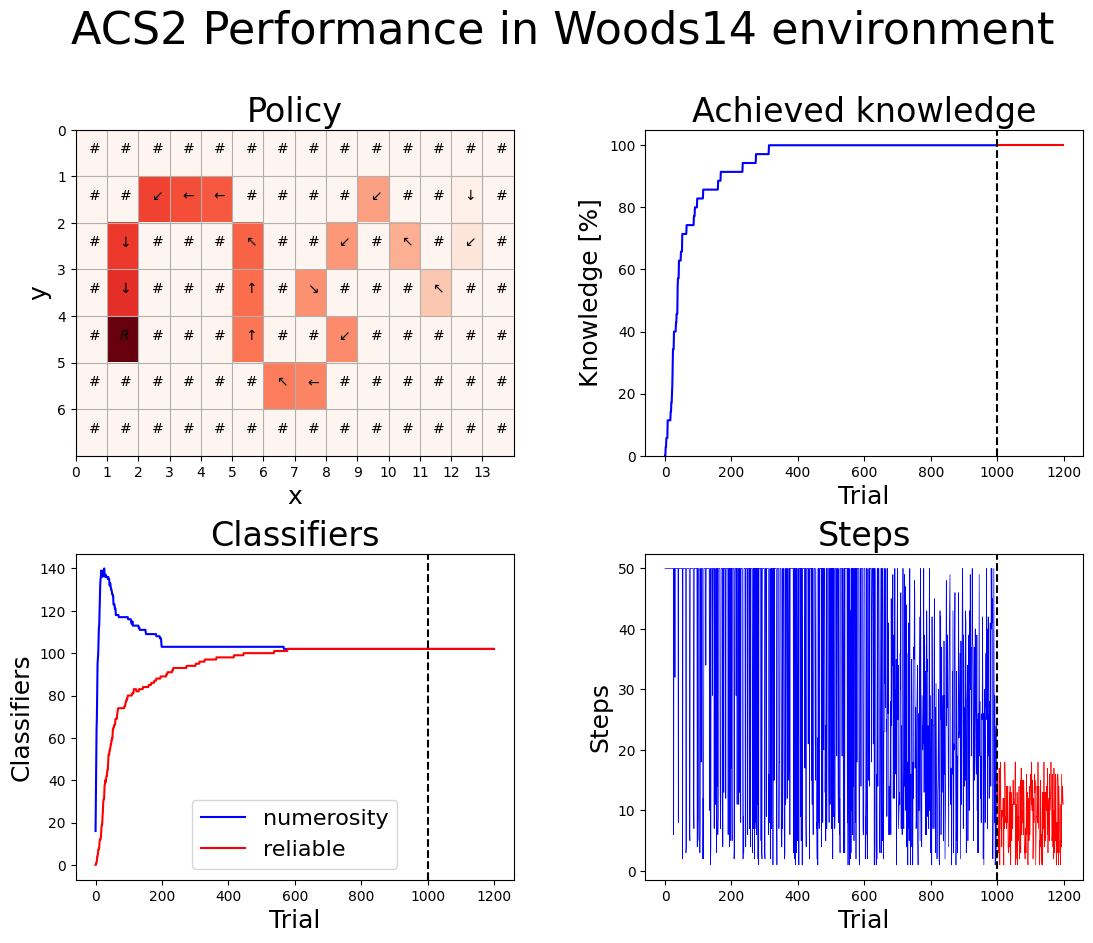

In [22]:
plot_performance(agent_woods14, woods14, woods14_metrics_df, cfg, 'Woods14')

In [23]:
# define environment
corridor40 = gym.make('MazeF3-v0')

# explore
agent_corridor40 = ACS2(cfg)
population_corridor40_explore, metrics_corridor40_explore = agent_corridor40.explore(corridor40, 1000)

# exploit
_, metrics_corridor40_exploit = agent_corridor40.exploit(corridor40, 200)


AttributeError: 'TimeLimit' object has no attribute 'exploit'